In [12]:
import pandas as pd
import numpy as np
import pandas_ta as pta
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dense, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import datetime

# 그래프 스타일 설정
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['axes.unicode_minus'] = False

# ---------------------------
# NASDAQ 종목 목록 가져오기
# ---------------------------
print("📜 NASDAQ 전체 종목 리스트를 가져와 상위 100개를 선택합니다...")
nasdaq_list = fdr.StockListing('NASDAQ')

# 전체 목록에서 알파벳 순서대로 100개만 선택
nasdaq_100_df = nasdaq_list.head(100)

tickers = nasdaq_100_df['Symbol'].tolist()
print(f"✅ 총 {len(tickers)}개의 종목을 확인했습니다.")
stock_names_df = nasdaq_100_df.set_index('Symbol')

📜 NASDAQ 전체 종목 리스트를 가져와 상위 100개를 선택합니다...


100%|██████████████████████████████████████| 3694/3694 [00:09<00:00, 400.04it/s]


✅ 총 100개의 종목을 확인했습니다.


In [13]:
# ---------------------------
# 금융 데이터 수집
# ---------------------------
start_date = '2022-01-01'
end_date = datetime.date.today().strftime('%Y-%m-%d')
all_data = {}

print("📈 NASDAQ 종목 데이터 수집을 시작합니다...")
for ticker in tickers:
    try:
        stock_name = stock_names_df.loc[ticker, 'Name']
        df = fdr.DataReader(ticker, start_date, end_date)
        
        if df.empty:
            print(f"⚠️ {stock_name} ({ticker}) 데이터를 가져올 수 없습니다. 건너뜁니다.")
            continue

        rename_dict = {'Open': 'PX_OPEN', 'High': 'PX_HIGH', 'Low': 'PX_LOW', 'Close': 'PX_LAST', 'Volume': 'PX_VOLUME'}
        df.rename(columns=rename_dict, inplace=True)
        
        if 'Change' in df.columns:
            df = df.drop(columns='Change')
            
        all_data[stock_name] = df
        print(f"- {stock_name} ({ticker}) 데이터 수집 완료")
    except Exception as e:
        print(f"❌ {ticker} 처리 중 오류 발생: {e}")

if not all_data:
    print("❌ 수집된 데이터가 없어 분석을 종료합니다.")
else:
    data = pd.concat(all_data, axis=1, keys=all_data.keys())
    data.index.name = 'Dates'
    data.columns.names = ['Ticker', 'Feature']
    print("✅ 데이터 준비 완료!")

📈 NASDAQ 종목 데이터 수집을 시작합니다...
- NVIDIA Corp (NVDA) 데이터 수집 완료
- Microsoft Corp (MSFT) 데이터 수집 완료
- Apple Inc (AAPL) 데이터 수집 완료
- Amazon.com Inc (AMZN) 데이터 수집 완료
- Meta Platforms Inc (META) 데이터 수집 완료
- Broadcom Inc (AVGO) 데이터 수집 완료
- Alphabet Inc Class A (GOOGL) 데이터 수집 완료
- Alphabet Inc Class C (GOOG) 데이터 수집 완료
- Tesla Inc (TSLA) 데이터 수집 완료
- Netflix Inc (NFLX) 데이터 수집 완료
- Costco Wholesale Corp (COST) 데이터 수집 완료
- Palantir Technologies Inc (PLTR) 데이터 수집 완료
- ASML Holding NV ADR (ASML) 데이터 수집 완료
- T-Mobile US Inc (TMUS) 데이터 수집 완료
- Advanced Micro Devices Inc (AMD) 데이터 수집 완료
- Cisco Systems Inc (CSCO) 데이터 수집 완료
- AstraZeneca PLC ADR (AZN) 데이터 수집 완료
- Linde PLC (LIN) 데이터 수집 완료
- PepsiCo Inc (PEP) 데이터 수집 완료
- Texas Instruments Inc (TXN) 데이터 수집 완료
- Intuit Inc (INTU) 데이터 수집 완료
- Booking Holdings Inc (BKNG) 데이터 수집 완료
- Shopify Inc (SHOP) 데이터 수집 완료
- PDD Holdings Inc ADR (PDD) 데이터 수집 완료
- Qualcomm Inc (QCOM) 데이터 수집 완료
- Intuitive Surgical Inc (ISRG) 데이터 수집 완료
- Applovin Corp (APP) 데이터 수집 완료
- Amgen 

In [14]:
# ---------------------------
# 특징 공학 (Feature Engineering) 및 정규화
# ---------------------------
indices = list(data.columns.get_level_values(0).unique())
index_dict = {}
print("\n📊 기술적 지표 계산 및 데이터 정규화를 시작합니다...")
for index in indices:
    df = data[index].copy()
    rename_dict = {'PX_OPEN': 'open', 'PX_HIGH': 'high', 'PX_LOW': 'low', 'PX_LAST': 'close', 'PX_VOLUME': 'volume'}
    df.rename(columns=rename_dict, inplace=True)

    df.dropna(subset=['open', 'high', 'low', 'close', 'volume'], inplace=True)
    if df.empty or df['volume'].isnull().all() or (df['volume'] == 0).all(): continue
    df['volume'] = df['volume'].astype('int64')

    # 기술적 지표 계산
    df.ta.rsi(append=True)
    df.ta.mfi(append=True)
    df.ta.adx(append=True)
    df.ta.obv(append=True)
    df.ta.atr(append=True)
    df.ta.ema(length=14, append=True)
    
    bbands = df.ta.bbands(length=20, append=False)
    if bbands is not None and not bbands.empty:
        df['Boll_upper'] = bbands[f'BBU_20_2.0']
        df['Boll_mid'] = bbands[f'BBM_20_2.0']
        df['Boll_lower'] = bbands[f'BBL_20_2.0']

    macd = df.ta.macd(fast=14, slow=30, append=False)
    if macd is not None and not macd.empty:
        df['MACD'] = macd[f'MACD_14_30_9']
    
    if 'close' in df.columns:
        for i in range(1, 49):
            df[f'LR_{i}'] = np.log(df['close']) - np.log(df['close'].shift(i))
    
    df.dropna(inplace=True, axis=0)
    if df.empty: continue
            
    # 0-1 정규화 (Min-Max Scaling)
    for col in df.columns:
        min_val, max_val = df[col].min(), df[col].max()
        if max_val - min_val > 0:
            df[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            df[col] = 0
            
    index_dict[index] = df

print("✅ 모든 종목의 특징 생성 및 정규화 완료!")


📊 기술적 지표 계산 및 데이터 정규화를 시작합니다...


/var/folders/8l/4_fpxyr51vdgqv070yhckk540000gn/T/ipykernel_13553/3650971179.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.18269382e+10 1.11422155e+10 1.07613804e+10 1.74195627e+10
 1.35611668e+10 1.27435872e+10 1.36963324e+10 9.31014701e+09
 1.01656866e+10 1.37681698e+10 1.81555353e+10 1.92071015e+10
 1.26495931e+10 1.15760998e+10 9.35712283e+09 1.12478215e+10
 1.10425223e+10 1.61734372e+10 1.15647569e+10 1.89124691e+10
 1.57503918e+10 2.40919496e+10 1.60813972e+10 1.18677367e+10
 1.39494094e+10 1.07925305e+10 1.13999715e+10 1.12615251e+10
 1.10850657e+10 1.09638913e+10 9.28665944e+09 1.28657129e+10
 1.34065110e+10 1.16716376e+10 1.05804806e+10 1.06631108e+10
 1.30412592e+10 1.72623394e+10 1.37318808e+10 1.24456772e+10
 1.24128971e+10 7.98164274e+09 6.82465760e+09 9.27129584e+09
 9.91788528e+09 8.04842361e+09 7.95986978e+09 7.25049104e+09
 9.55165129e+09 7.97796255e+09 7.75369270e+09 7.37274301

✅ 모든 종목의 특징 생성 및 정규화 완료!


In [15]:
# ---------------------------
# 모델 입력을 위한 데이터 재구성
# ---------------------------
index_keys = list(index_dict.keys())
for index in index_keys:
    if index_dict[index].empty:
        print(f"🗑️ 특징 생성 후 데이터가 없는 종목 '{index}'을/를 제외합니다.")
        del index_dict[index]
        
indices = list(index_dict.keys())
if not indices:
    print("❌ 처리할 데이터가 없습니다. 프로그램을 종료합니다.")
else:
    min_len = min(len(df) for df in index_dict.values())
    print(f"\n📏 모든 데이터 길이를 {min_len}으로 통일합니다.")
    
    trimmed_index_dict = {index: df.tail(min_len) for index, df in index_dict.items()}
    
    n_timesteps = min_len
    n_features = trimmed_index_dict[indices[0]].shape[1]
    n_indices = len(indices)
    
    x_data = np.array([df.values for df in trimmed_index_dict.values()])
    x = x_data.reshape(n_indices, n_timesteps, n_features, 1).astype('float32')
    print(f"🧠 모델 입력 데이터(x) 형태: {x.shape}")


📏 모든 데이터 길이를 55으로 통일합니다.
🧠 모델 입력 데이터(x) 형태: (100, 55, 66, 1)


In [16]:
# ---------------------------
# 모델 구축
# ---------------------------
args = {
    'n_clusters': 7,
    'batch_size': 16,
    'epochs': 50,
    'save_dir': 'results_nasdaq'
}

if not os.path.exists(args['save_dir']):
    os.makedirs(args['save_dir'])

input_shape = x.shape[1:]
filters = [32, 64, 128, 10]

# --- 인코더 (Encoder) ---
encoder_input = Input(shape=input_shape, name='encoder_input')
x_enc = Conv2D(filters[0], 5, padding='same', activation='relu')(encoder_input)
x_enc = Conv2D(filters[1], 5, padding='same', activation='relu')(x_enc)
conv3_output = Conv2D(filters[2], 3, padding='valid', activation='relu')(x_enc)
flatten_output = Flatten()(conv3_output)
embedding = Dense(units=filters[3], name='embedding')(flatten_output)
encoder = Model(encoder_input, embedding, name='encoder')

# --- 디코더 (Decoder) ---
decoder_input = Input(shape=(filters[3],), name='decoder_input')
x_dec = Dense(units=np.prod(conv3_output.shape[1:]), activation='relu')(decoder_input)
x_dec = Reshape(conv3_output.shape[1:])(x_dec)
x_dec = Conv2DTranspose(filters[1], 3, padding='valid', activation='relu')(x_dec)
x_dec = Conv2DTranspose(filters[0], 5, padding='same', activation='relu')(x_dec)
decoder_output = Conv2DTranspose(input_shape[2], 5, padding='same')(x_dec)
decoder = Model(decoder_input, decoder_output, name='decoder')

# --- 오토인코더 (Autoencoder) ---
autoencoder = Model(encoder.input, decoder(encoder.output), name='autoencoder')
print("\n✅ 오토인코더 모델을 성공적으로 구축했습니다.")
autoencoder.summary()


✅ 오토인코더 모델을 성공적으로 구축했습니다.


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 55, 66, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 55, 66, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 55, 66, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 53, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 434176)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 10)             │     4,341,770 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 55, 66, 1)      │     4,901,761 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,369,483 (35.74 MB)

 Trainable params: 9,369,483 (35.74 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# ---------------------------
# 모델 학습
# ---------------------------
autoencoder.compile(optimizer='adam', loss='mse')
csv_logger = CSVLogger(os.path.join(args['save_dir'], 'pretrain-log.csv'))
model_checkpoint = ModelCheckpoint(
    filepath=os.path.join(args['save_dir'], 'best_model.keras'),
    monitor='loss',
    save_best_only=True
)

print("\n🔥 모델 학습을 시작합니다...")
autoencoder.fit(x, x,
                batch_size=args['batch_size'],
                epochs=args['epochs'],
                verbose=1,
                callbacks=[csv_logger, model_checkpoint])
print('✅ 학습 완료!')


🔥 모델 학습을 시작합니다...
Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - loss: 0.9239
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - loss: 0.3296
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - loss: 0.1136
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - loss: 0.0660
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - loss: 0.0385
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - loss: 0.0296
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 0.0252
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - loss: 0.0237
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - loss: 0.0235
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - loss: 0.0226
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - loss: 0.0223
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 0.0221
Epoch 13/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - loss: 0.0220
Epoch 14/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.0220
Epoch 15/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.0219   
Epoch 16/50
7/7 ━━━━━━━━━━━━━

In [18]:
# ---------------------------
# 클러스터링 및 평가
# ---------------------------
print("\n[딥러닝 방식] 특징 벡터 추출 및 클러스터링...")
features_ae = encoder.predict(x)
agg_clustering = AgglomerativeClustering(n_clusters=args['n_clusters'])
pred_ae = agg_clustering.fit_predict(features_ae)
cluster_df_ae = pd.DataFrame({'종목명': indices, '클러스터': pred_ae})

print("[고전 방식] PCA 차원 축소 및 클러스터링...")
feature_list = [df.values.flatten() for df in trimmed_index_dict.values()]
X_features = np.array(feature_list)
pca = PCA(n_components=10, random_state=42)
features_pca = pca.fit_transform(X_features)
kmeans = KMeans(n_clusters=args['n_clusters'], random_state=42, n_init='auto')
pred_pca = kmeans.fit_predict(features_pca)
cluster_df_pca = pd.DataFrame({'종목명': indices, '클러스터': pred_pca})

# --- 결과 출력 ---
print("\n" + "="*50)
print("     💻 딥러닝 Autoencoder 방식 클러스터링 결과 💻")
print("="*50)
for i in sorted(cluster_df_ae['클러스터'].unique()):
    cluster_indices = cluster_df_ae[cluster_df_ae['클러스터'] == i]['종목명'].values
    print(f'--- 클러스터 {i} ---\n{list(cluster_indices)}\n')

print("\n" + "="*50)
print("     💿 고전 PCA + K-Means 방식 클러스터링 결과 💿")
print("="*50)
for i in sorted(cluster_df_pca['클러스터'].unique()):
    cluster_indices = cluster_df_pca[cluster_df_pca['클러스터'] == i]['종목명'].values
    print(f'--- 클러스터 {i} ---\n{list(cluster_indices)}\n')

# --- 성능 평가 ---
silhouette_ae = silhouette_score(features_ae, pred_ae)
silhouette_pca = silhouette_score(features_pca, pred_pca)
print("\n" + "="*50)
print("     💯 성능 평가 (실루엣 점수) 💯")
print("="*50)
print(f"딥러닝 방식 실루엣 점수: {silhouette_ae:.4f}")
print(f"고전 방식(PCA) 실루엣 점수: {silhouette_pca:.4f}")

if silhouette_ae > silhouette_pca:
    print("\n💡 결론: 딥러닝 방식의 군집 분리 성능이 더 우수합니다.")
else:
    print("\n💡 결론: 고전 방식(PCA)의 군집 분리 성능이 더 우수합니다.")


[딥러닝 방식] 특징 벡터 추출 및 클러스터링...
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 429ms/step
[고전 방식] PCA 차원 축소 및 클러스터링...

     💻 딥러닝 Autoencoder 방식 클러스터링 결과 💻
--- 클러스터 0 ---
['Apple Inc', 'Alphabet Inc Class A', 'Alphabet Inc Class C', 'Tesla Inc', 'Advanced Micro Devices Inc', 'AstraZeneca PLC ADR', 'Shopify Inc', 'PDD Holdings Inc ADR', 'Amgen Inc', 'Sanofi SA ADR', 'Synopsys Inc', 'Interactive Brokers Group Inc', 'Cadence Design Systems Inc', 'CSX Corp', 'Workday Inc', 'Alnylam Pharmaceuticals Inc', 'Fastenal Co', 'Paccar Inc', 'IDEXX Laboratories Inc', 'Exelon Corp', 'eBay Inc', 'Baker Hughes Co', 'Electronic Arts Inc', 'Keurig Dr Pepper Inc', 'Monolithic Power Systems Inc']

--- 클러스터 1 ---
['Costco Wholesale Corp', 'Palantir Technologies Inc', 'Linde PLC', 'Intuitive Surgical Inc', 'Applovin Corp', 'Gilead Sciences Inc', 'Automatic Data Processing Inc', 'Strategy Inc', 'CME Group Inc', 'Cintas Corp', 'Equinix Inc', 'Monster Beverage Corp', 'Roper Technologies Inc', 'Paychex Inc', 'Trip.com Group Ltd ADR

/Library/anaconda3/envs/ppp/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46373 (\N{HANGUL SYLLABLE DIB}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/anaconda3/envs/ppp/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47084 (\N{HANGUL SYLLABLE REO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/anaconda3/envs/ppp/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45789 (\N{HANGUL SYLLABLE NING}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/anaconda3/envs/ppp/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/anaconda3/envs/ppp/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49885 (\N{HANGUL SYLLABLE SIG}) missing from font(

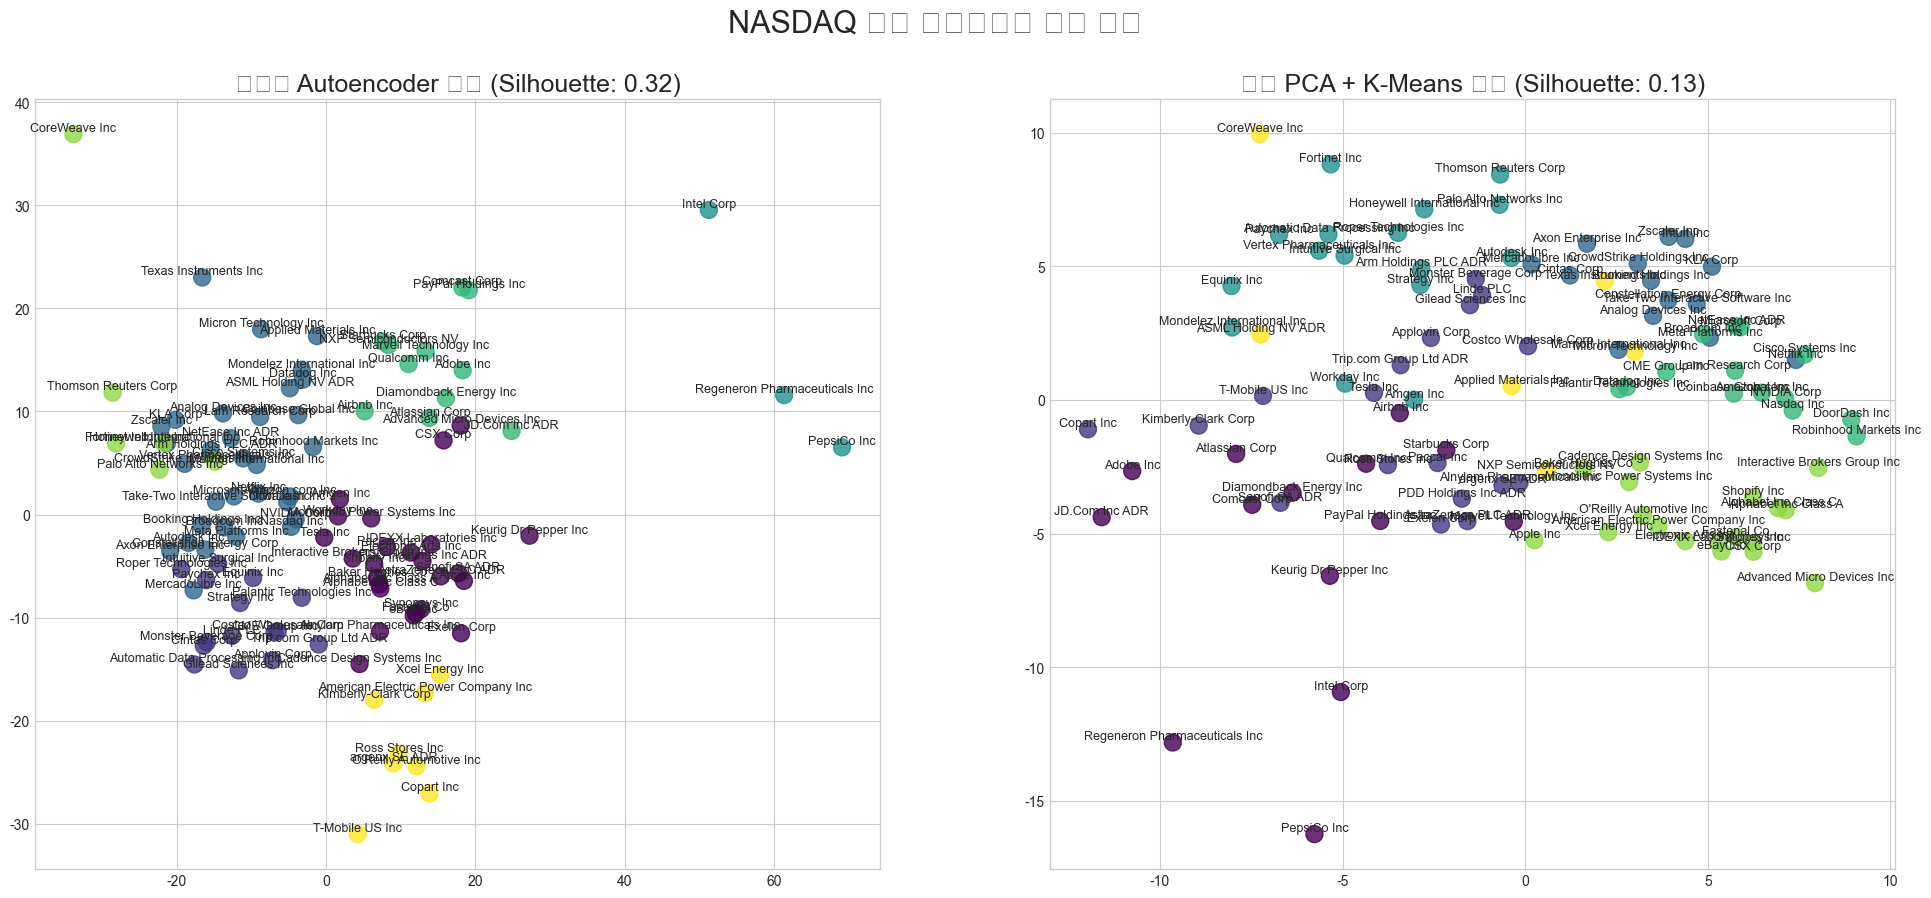

In [19]:
# ---------------------------
# 시각화
# ---------------------------
pca_2d = PCA(n_components=2, random_state=42)
features_ae_2d = pca_2d.fit_transform(features_ae)
features_pca_2d = pca_2d.fit_transform(features_pca)

fig, axes = plt.subplots(1, 2, figsize=(24, 10))
fig.suptitle('NASDAQ 종목 클러스터링 결과 비교', fontsize=22, y=0.97)

# 딥러닝 결과 시각화
axes[0].set_title(f'딥러닝 Autoencoder 방식 (Silhouette: {silhouette_ae:.2f})', fontsize=18)
scatter1 = axes[0].scatter(features_ae_2d[:, 0], features_ae_2d[:, 1], c=pred_ae, cmap='viridis', s=150, alpha=0.8)
for i, txt in enumerate(indices):
    axes[0].annotate(txt, (features_ae_2d[i, 0], features_ae_2d[i, 1]), fontsize=9, ha='center', va='bottom')

# 고전 방식 결과 시각화
axes[1].set_title(f'고전 PCA + K-Means 방식 (Silhouette: {silhouette_pca:.2f})', fontsize=18)
scatter2 = axes[1].scatter(features_pca_2d[:, 0], features_pca_2d[:, 1], c=pred_pca, cmap='viridis', s=150, alpha=0.8)
for i, txt in enumerate(indices):
    axes[1].annotate(txt, (features_pca_2d[i, 0], features_pca_2d[i, 1]), fontsize=9, ha='center', va='bottom')

plt.show()